## 데이터 군집

이 노트북에서 군집(clustering)을 간단히 소개하고 umap을 사용해 군집의 성능을 조사하는 방법을 알아 보겠습니다. 이 노트북은 사이킷런의 군집 [튜토리얼](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)을 참고했습니다.

먼저 수동 방법을 알아 보고 그다음 실루엣 점수와 클러스터 크기를 사용해 자동 방법을 알아 보겠습니다.

먼저 데이터를 로드하고 변환한 다음 임베딩합니다.

In [9]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from scipy.sparse import vstack, hstack


def format_raw_df(df):
    """
    데이터를 정제하고 질문과 대답을 합칩니다.
    :param df: 원본 DataFrame
    :return: 처리된 DataFrame
    """
    # 타입을 고치고 인덱스를 설정합니다.
    df["PostTypeId"] = df["PostTypeId"].astype(int)
    df["Id"] = df["Id"].astype(int)
    df["AnswerCount"] = df["AnswerCount"].fillna(-1)
    df["AnswerCount"] = df["AnswerCount"].astype(int)
    df["OwnerUserId"].fillna(-1, inplace=True)
    df["OwnerUserId"] = df["OwnerUserId"].astype(int)
    df.set_index("Id", inplace=True, drop=False)

    df["is_question"] = df["PostTypeId"] == 1

    # 문서화된 것 이외의 PostTypeId를 필터링합니다.
    df = df[df["PostTypeId"].isin([1, 2])]

    # 질문과 대답을 연결합니다.
    df = df.join(
        df[["Id", "Title", "body_text", "Score", "AcceptedAnswerId"]],
        on="ParentId",
        how="left",
        rsuffix="_question",
    )
    return df

In [10]:
def get_split_by_author(
    posts, author_id_column="OwnerUserId", test_size=0.3, random_state=40
):
    """
    훈련 세트와 테스트 세트로 나눕니다.
    작성자가 두 세트 중에 하나에만 등장하는 것을 보장합니다.
    :param posts: 모든 포스트와 레이블
    :param author_id_column: author_id가 들어 있는 열 이름
    :param test_size: 테스트 세트로 할당할 비율
    :param random_state: 랜덤 시드
    """
    splitter = GroupShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    splits = splitter.split(posts, groups=posts[author_id_column])
    train_idx, test_idx = next(splits)
    return posts.iloc[train_idx, :], posts.iloc[test_idx, :]


In [11]:
def add_v1_features(df):
    """
    입력 DataFrame에 첫 번째 특성을 추가합니다.
    :param df: 질문 DataFrame
    :return: 특성이 추가된 DataFrame
    """
    df["action_verb_full"] = (
        df["full_text"].str.contains("can", regex=False)
        | df["full_text"].str.contains("What", regex=False)
        | df["full_text"].str.contains("should", regex=False)
    )
    df["language_question"] = (
        df["full_text"].str.contains("punctuate", regex=False)
        | df["full_text"].str.contains("capitalize", regex=False)
        | df["full_text"].str.contains("abbreviate", regex=False)
    )
    df["question_mark_full"] = df["full_text"].str.contains("?", regex=False)
    df["text_len"] = df["full_text"].str.len()
    return df


def add_text_features_to_df(df):
    """
    DataFrame에 특성을 추가합니다.
    :param df: DataFrame
    :return: 특성이 추가된 DataFrame
    """
    df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
    df = add_v1_features(df.copy())

    return df


In [12]:
def get_vectorized_series(text_series, vectorizer):
    """
    사전 훈련된 벡터화 객체를 사용해 입력 시리즈를 벡터화합니다.
    :param text_series: 텍스트의 판다스 시리즈
    :param vectorizer: 사전 훈련된 sklearn의 벡터화 객체
    :return: 벡터화된 특성 배열
    """
    vectors = vectorizer.transform(text_series)
    vectorized_series = [vectors[i] for i in range(vectors.shape[0])]
    return vectorized_series


In [13]:
def train_vectorizer(df):
    """
    벡터화 객체를 훈련합니다.
    훈련 데이터와 그 외 데이터를 변환하는데 사용할 벡터화 객체를 반환합니다.
    :param df: 벡터화 객체를 훈련하는데 사용할 데이터
    :return: 훈련된 벡터화 객체
    """
    vectorizer = TfidfVectorizer(
        strip_accents="ascii", min_df=5, max_df=0.5, max_features=10000
    )

    vectorizer.fit(df["full_text"].copy())
    return vectorizer


In [14]:
import pandas as pd
import spacy
import umap
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from ml_editor.data_processing import format_raw_df, get_split_by_author, add_text_features_to_df, get_vectorized_series, train_vectorizer

data_path = Path('data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df["is_question"]].copy())

train_author, test_author = get_split_by_author(df[df["is_question"]])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat", "lemmatizer"])
train_author["vectors"] = train_author["full_text"].apply(lambda x: nlp(x).vector)
vectorized_features= np.vstack(train_author["vectors"])

In [16]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[K 평균](https://en.wikipedia.org/wiki/K-means_clustering)을 사용해 데이터를 클러스터링해 보죠. K 평균을 사용하려면 원하는 클러스터 개수를 매개변수로 지정해야 합니다. 3개의 클러스터로 시작해 보겠습니다. 클러스터마다 다른 색깔을 입혀 UMAP으로 결과를 시각화합니다.

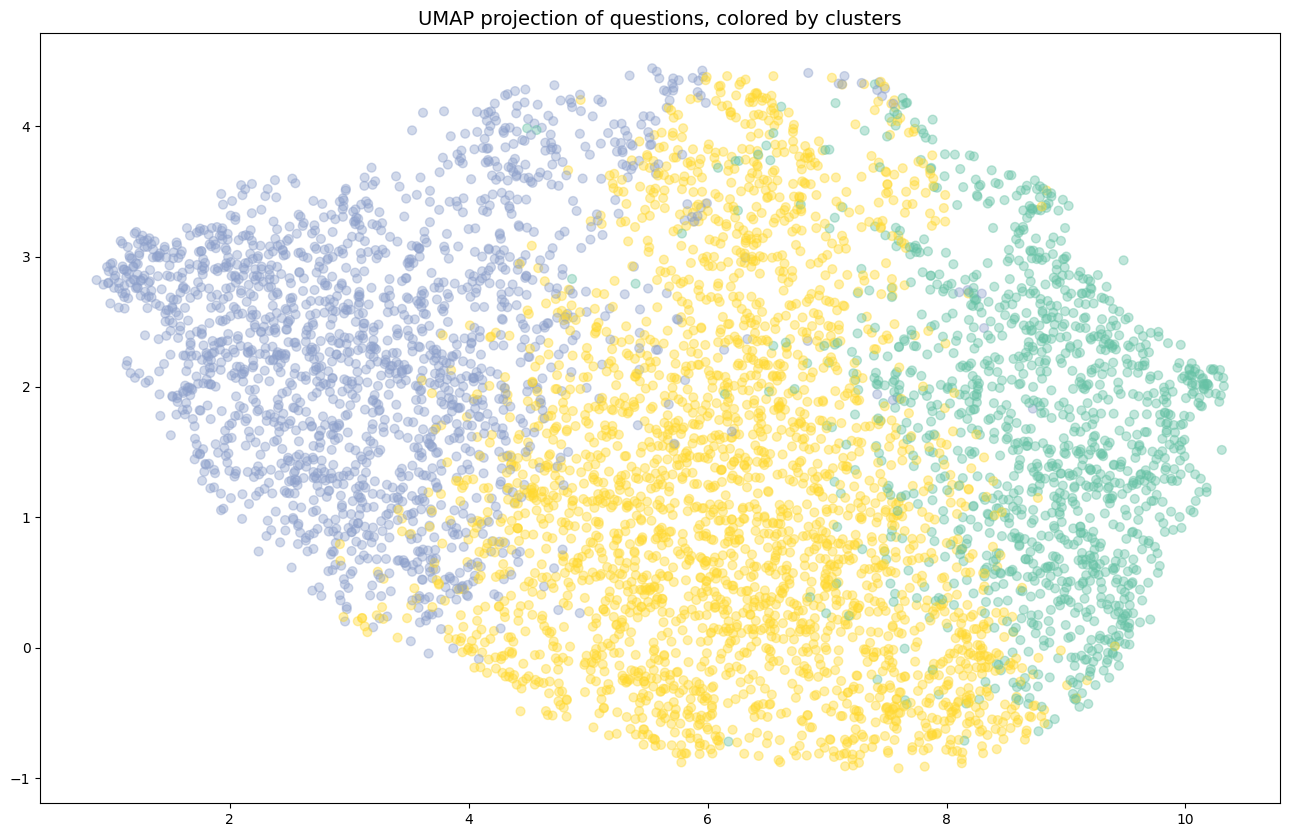

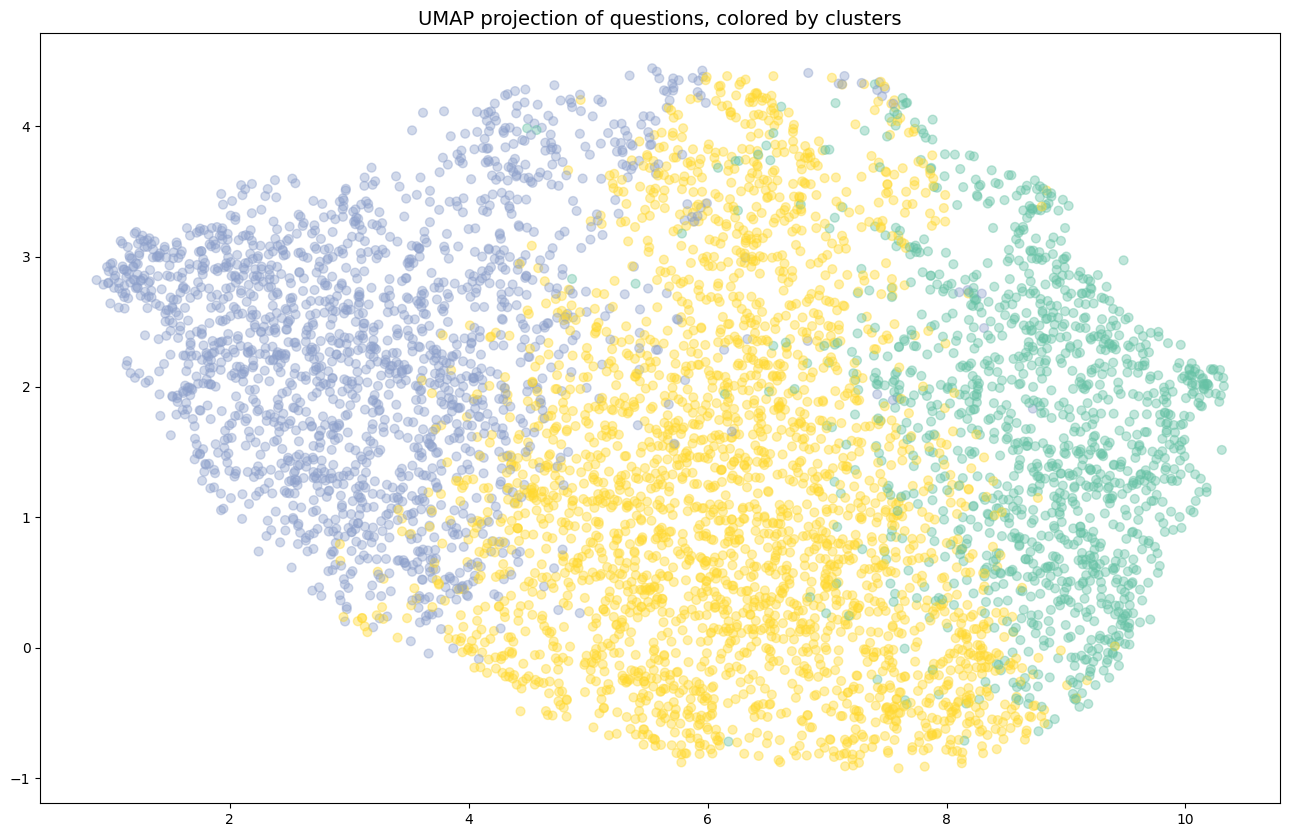

In [18]:
n_cluster = 3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))

# 차원 축소 안된 feature를 사용하여 군집 알고리즘 훈련
clus = KMeans(n_clusters=n_cluster, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# 차원 축소된 feature를 사용하여 시각화
plt.scatter(umap_features[:, 0], umap_features[:, 1],
            c=[cmap(x/n_cluster) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14)
plt.savefig('images/bmlpa_figures/ch04-10.png', dpi=300)

#### 번역서 부록

KMeans 알고리즘을 사용할 때 각 샘플을 클러스터의 중심까지의 거리로 표현할 수 있습니다. `KMeans` 클래스의 `trasnform()` 메서드에서 이를 수행합니다.
여기에서 클러스터 개수는 3개 이므로 반환된 데이터의 특성 개수도 3개가 됩니다. 클러스터 중심까지 거리를 사용해 시각화를 하면 종종 더 나은 결과를 보여줍니다.

아래 코드는 `KMeans` 클래스의 `transform()` 메서드로 `vectorized_features`를 `transformed_features`로 변환한 후 UMAP으로 시각화하는 예입니다.

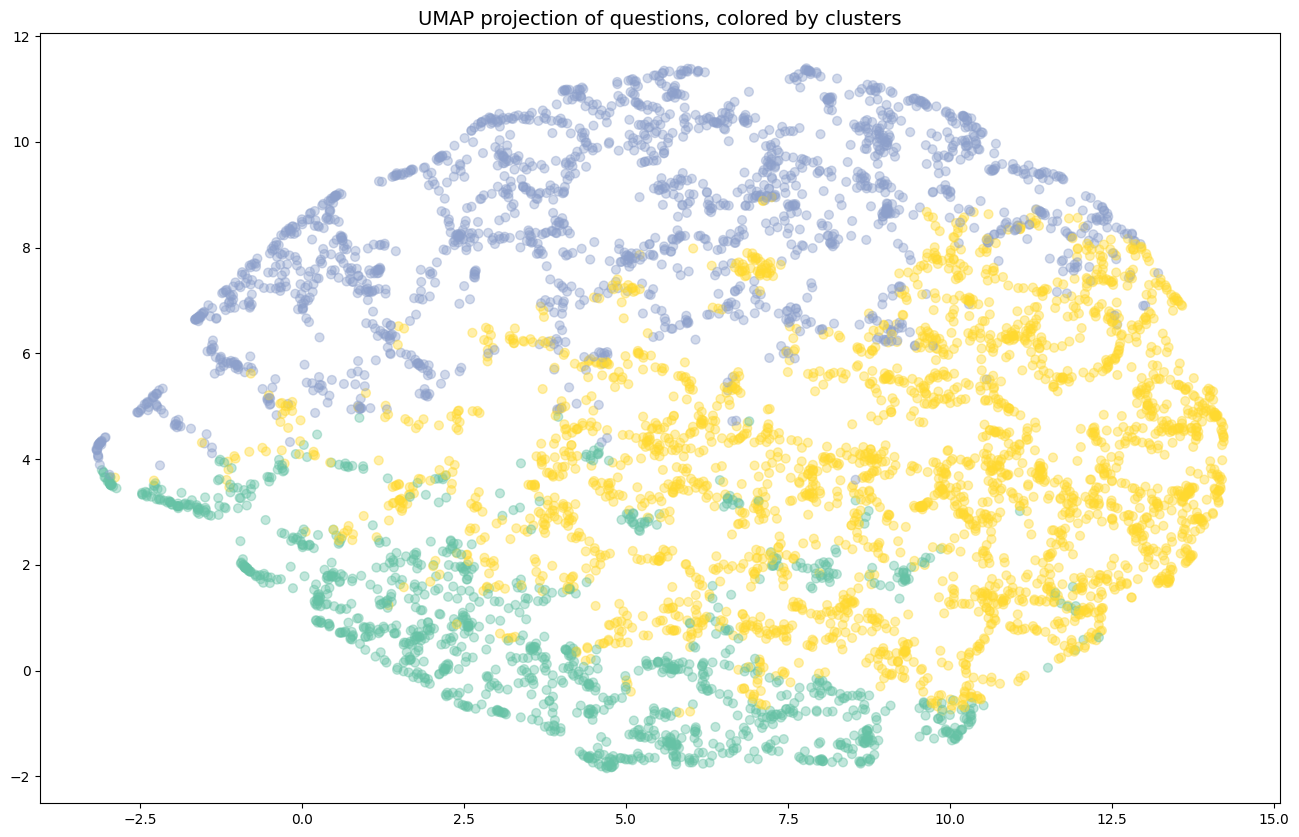

In [20]:
transformed_features = clus.transform(vectorized_features)

umap_features = umap_embedder.fit_transform(transformed_features)

# Plot the dimentionality reduced features on a 2D plane
fig = plt.figure(figsize = (16, 10))
plt.scatter(umap_features[:, 0], umap_features[:, 1],
            c=[cmap(x/n_cluster) for x in clusters], s=40, alpha=.4)

plt.title('UMAP projection of questions, colored by clusters', fontsize=14);
plt.savefig('images/bmlpa_figures/ch04-10A.png', dpi=300)

이 그래프에서는 올바른 클러스터 개수를 선택했는지 확실하지 않습니다. 어떤 영역은 특정 클러스터에 할당된 것 같지만 그렇지 않고 분할된 영역도 있습니다.
클러스터 개수를 바꾸어 시도해 보고 umap과 [실루엣 점수](https://en.wikipedia.org/wiki/Silhouette_(clustering))를 사용해 그래프를 그려 보겠습니다.

For n_clusters = 2 The average silhouette_score is : 0.2534662
0 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
0 cluster: ith_cluster_silhouette_values.shape[0]: 3142
1 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
1 cluster: ith_cluster_silhouette_values.shape[0]: 2534
(2, 300)
For n_clusters = 3 The average silhouette_score is : 0.17202856
0 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
0 cluster: ith_cluster_silhouette_values.shape[0]: 1778
1 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
1 cluster: ith_cluster_silhouette_values.shape[0]: 2661
2 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
2 cluster: ith_cluster_silhouette_values.shape[0]: 1237
(3, 300)
For n_clusters = 4 The average silhouette_score is : 0.10557536
0 cluster: type(ith_cluster_silhouette_values): <class 'numpy.ndarray'>
0 cluster: ith_cluster_silhouette_values.shape[0]: 1076
1 cluster: type(ith_clu

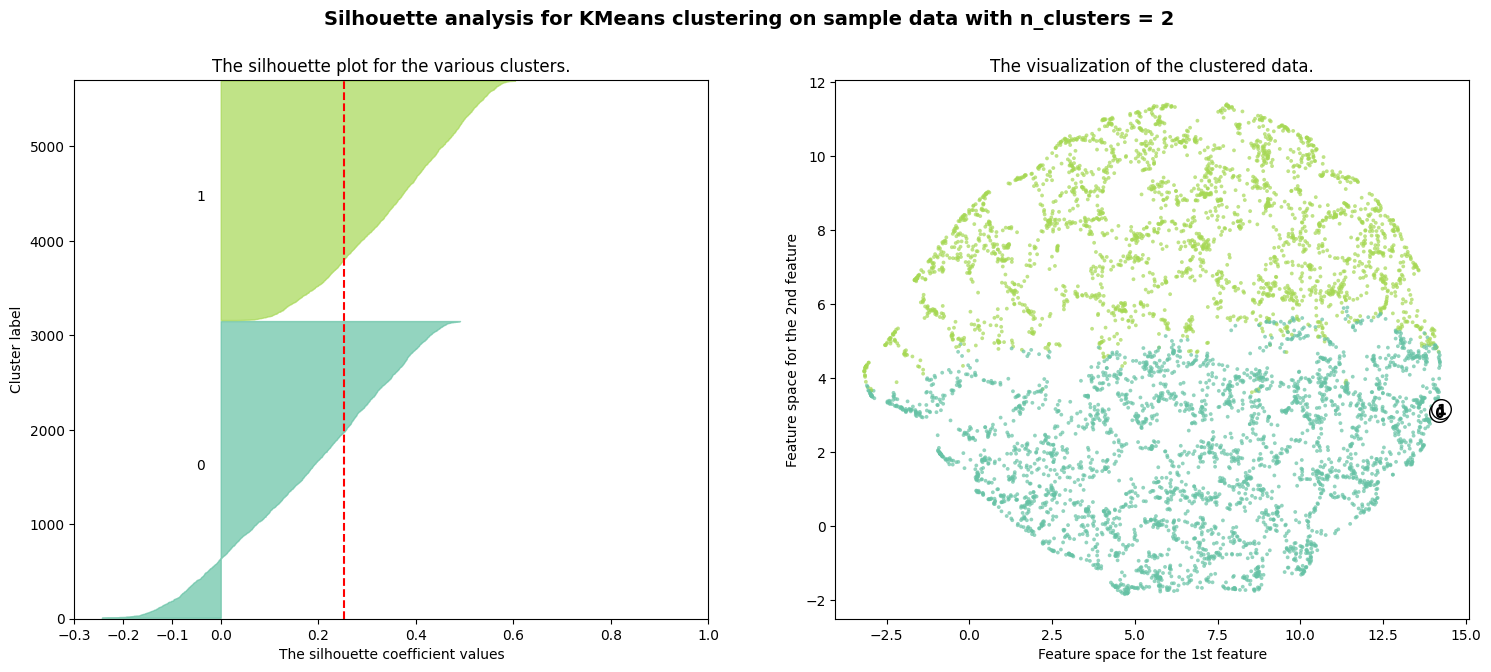

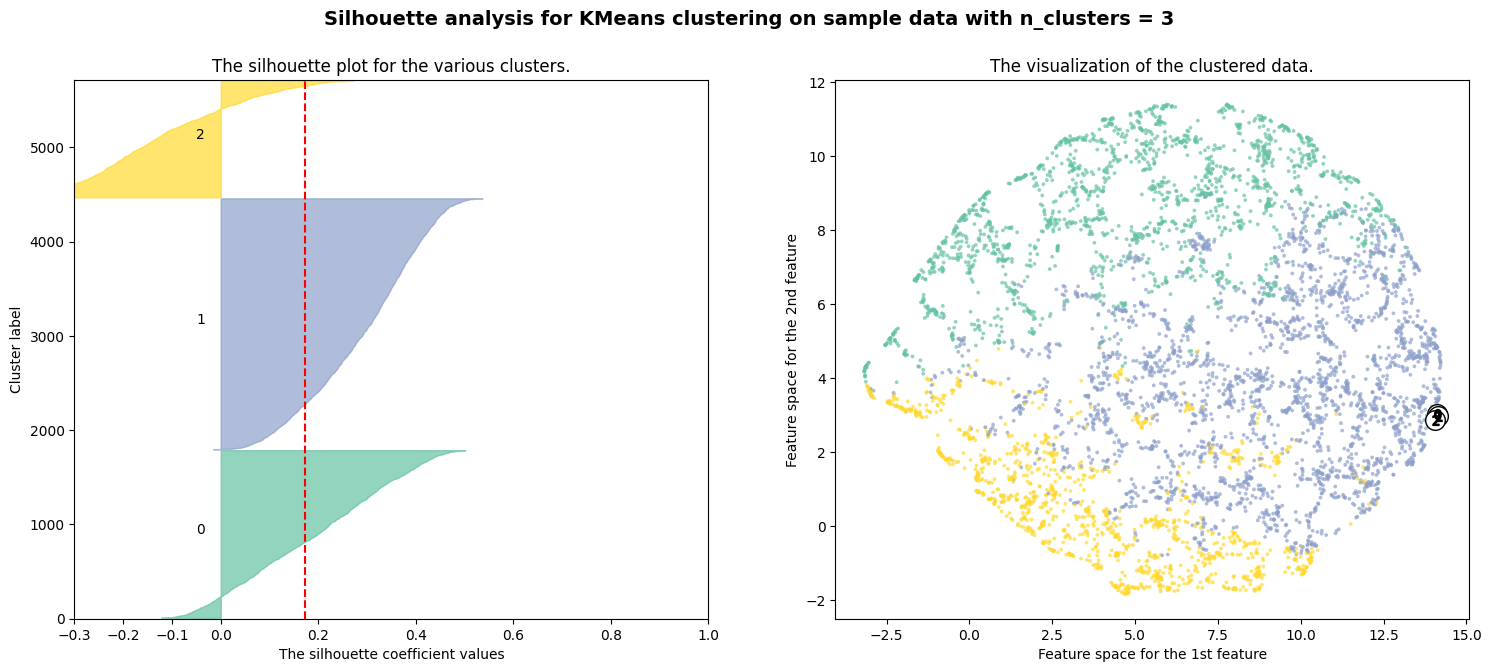

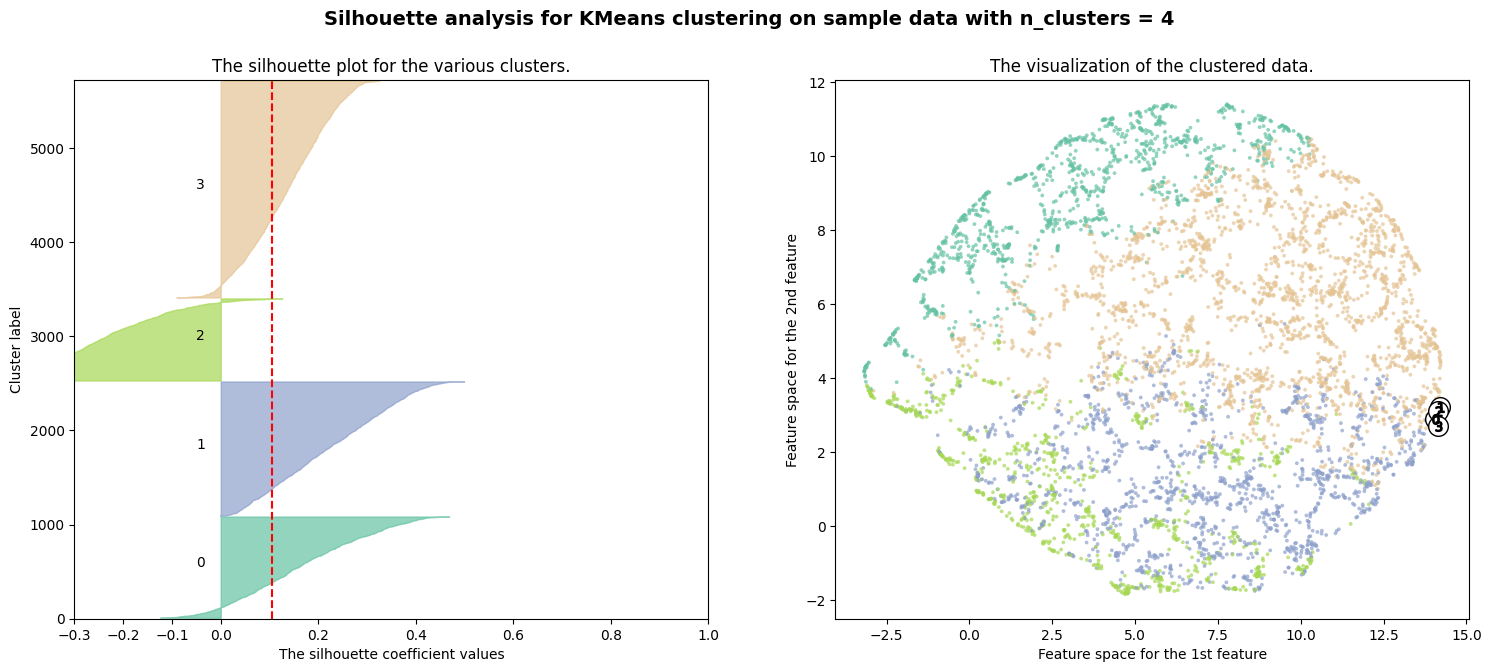

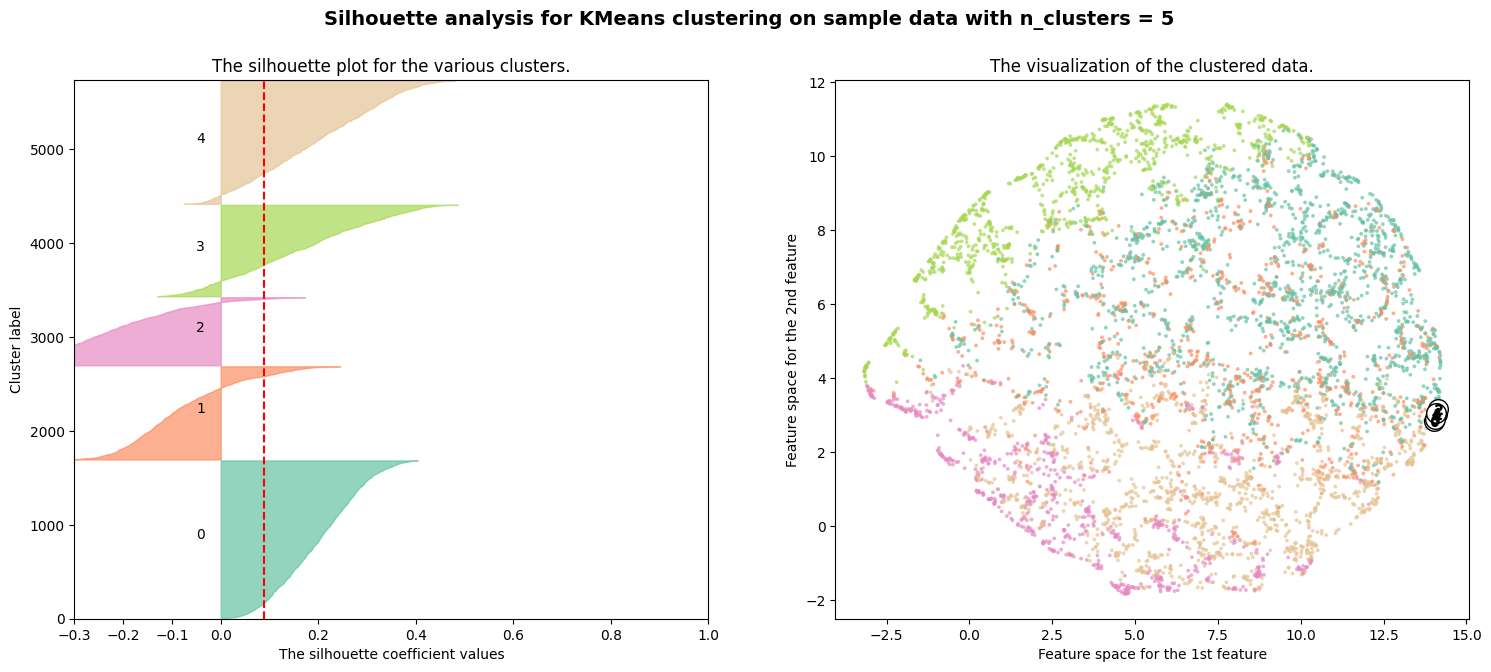

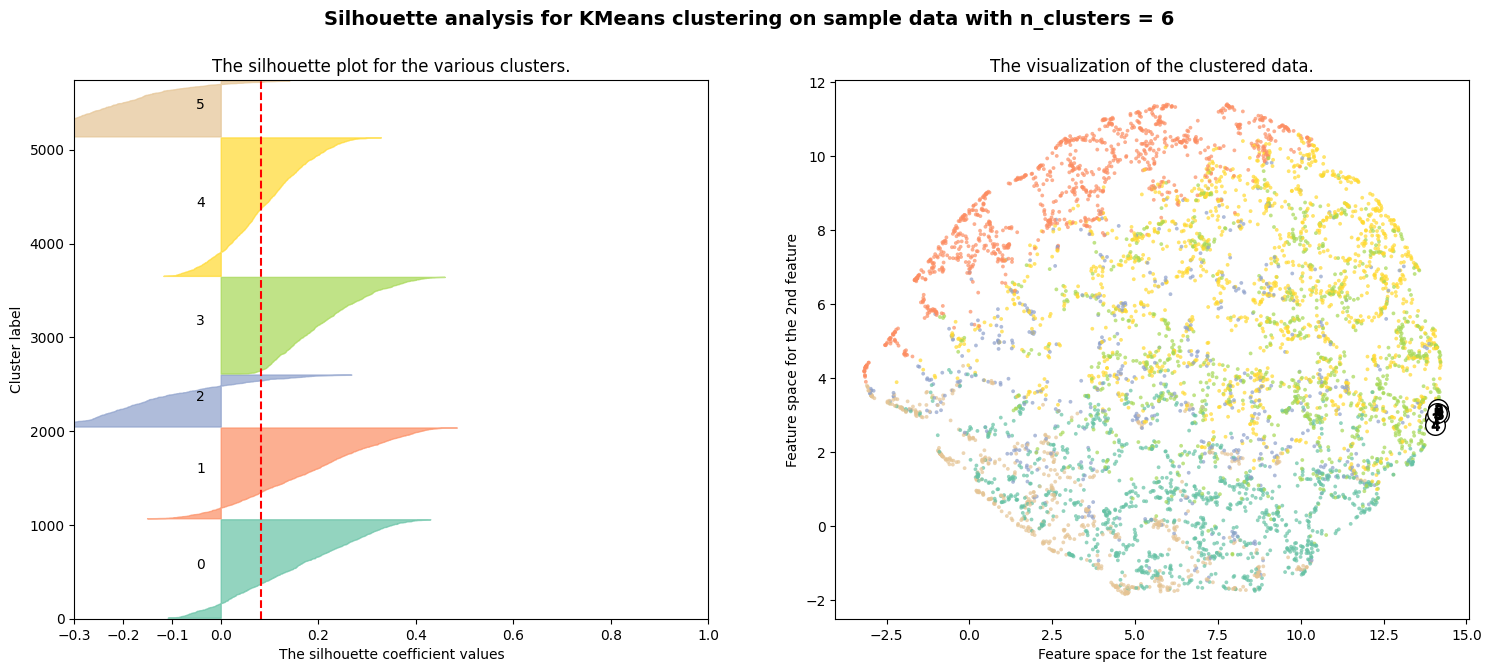

In [23]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # 1행 2열의 서브플롯을 만듭니다
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 첫 번째 서브플롯은 실루엣 그래프입니다
    # 실루엣 계수는 -1~1 사이이지만 이 예에서는 모두 [-0.1, 1] 사이에 있습니다
    ax1.set_xlim([-.3, .4])
    # (n_clusters+1)*10는 클러스터 실루엣 그래프 사이의 공백을 위한 것입니다
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])

    # n_cluster와 재현을 위한 random_state를 지정하여 K 평균 객체를 초기화합니다
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(to_clus)

    # silhouette_score 함수는 모든 샘플에 대한 평균을 반환합니다
    # 이를 통해 만들어진 클러스터의 조밀함과 차별성을 판단합니다
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 각 샘플에 대한 실루엣 점수를 계산합니다
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속한 샘플의 실루엣 점수를 찾아 정렬합니다
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        print(f"{i} cluster: type(ith_cluster_silhouette_values): {type(ith_cluster_silhouette_values)}")
        print(f"{i} cluster: ith_cluster_silhouette_values.shape[0]: {ith_cluster_silhouette_values.shape[0]}")

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 실루엣 그래프에 클러스터 번호로 레이블을 매깁니다
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 그래프를 위해 새로운 y_lower를 계산합니다
        y_lower = y_upper + 10  # 샘플일 0개일 경우를 위해 10을 더함

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # 평균 실루엣 점수로 수직선을 그립니다
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # ax1.set_yticks([])  # y축 레이블을 삭제합니다
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2차원 평면에 실제 클러스터를 그립니다
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # 클러스터에 레이블을 부여합니다
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # 클러스터 중심에 하얀 원을 그립니다
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')